In [1]:
import cv2

import numpy as np
import pandas as pd
from joblib import load, dump

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional)
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras import optimizers

nPoints = 18

KEYPOINTS = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16]]

POSE_PAIRS_MOD = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [8,11]]

def plotSinglePose(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        
        for pair in POSE_PAIRS:
            # Checking just xcoord for valid point is enough
            valid_pt1 = (posePoint[pair[0]][0] != -1)
            valid_pt2 = (posePoint[pair[1]][0] != -1)
            if valid_pt1 and valid_pt2:
                xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()

def plotSinglePose_mod(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        with plt.style.context('Solarize_Light2'):
            for pair in POSE_PAIRS_MOD:
                # Checking just xcoord for valid point is enough
                valid_pt1 = (posePoint[pair[0]][0] != -1)
                valid_pt2 = (posePoint[pair[1]][0] != -1)
                if valid_pt1 and valid_pt2:
                    xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                    ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                    plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()        

def genSalsa(seedPoses, salsaModel, steps = 8):
    seqLen = seedPoses.shape[1]
    for i in range(steps):
        y_pred = salsa_model.predict(seedPoses[:,-(seqLen):,:])
        seedPoses = np.append(seedPoses, [y_pred], axis=1)
    return seedPoses
        
def flat_to_pose(flatPose):
    pose_dim = flatPose.reshape((-1, 2))
    
    return {i:pose_dim[i].tolist() for i in range(0, len(pose_dim))}
    

pose_data_file = "../data/frames/forRNN_pose_by_daner.out"
pose_data_by_dancer = load(pose_data_file)

Using TensorFlow backend.
//anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/envs/metis/lib/python3.7/site-packages/tenso

In [2]:
dancers = len(pose_data_by_dancer)
X = []
y = []
seqLen = 8
slide = 1

for dancer in range(dancers):
    pose_coords = pose_data_by_dancer[dancer]
    poses = len(pose_coords)
    if poses<60:
        continue #go to next dancer
    
    for i in range(0, poses - seqLen, slide):
        X.append(pose_coords[i:i+seqLen])
        y.append(pose_coords[i+seqLen])

X = np.array(X)
y = np.array(y)

In [3]:
print(X.shape)
print(y.shape)

(34944, 8, 36)
(34944, 36)


In [34]:
salsa_model = load_model("../models/threelayerLSTM_relu_36kp_8seql_60iters.h5")

In [12]:
salsa_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8, 72)             31392     
_________________________________________________________________
lstm_8 (LSTM)                (None, 8, 72)             41760     
_________________________________________________________________
lstm_9 (LSTM)                (None, 72)                41760     
_________________________________________________________________
dense_3 (Dense)              (None, 36)                2628      
Total params: 117,540
Trainable params: 117,540
Non-trainable params: 0
_________________________________________________________________


In [13]:
early_stopping = EarlyStopping(monitor='loss', min_delta = 0.001, patience=6, verbose=1)
#tb = TensorBoard(histogram_freq=1, write_grads=True)

kpoints = 36
drop_prob = 0.1

# Model
print('Build model...')
salsa_model = Sequential()
salsa_model.add(LSTM(2*kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True))
#salsa_model.add(Dropout(drop_prob))
salsa_model.add(LSTM(2*kpoints, activation='relu', return_sequences=True))
#salsa_model.add(Dropout(drop_prob))
salsa_model.add(LSTM(2*kpoints, activation='relu', return_sequences=False))
#salsa_model.add(Dropout(drop_prob))
salsa_model.add(Dense(kpoints))
adm = optimizers.Adam(lr=0.01, decay=0.8)
salsa_model.compile(optimizer=adm, loss='mse', metrics=['mse'])
hist = salsa_model.fit(X, y, epochs=12, verbose=True)

Build model...
Epoch 1/12
34944/34944 [==============================] - 22s 625us/step - loss: 12048.1704 - mean_squared_error: 12048.1704
Epoch 2/12
34944/34944 [==============================] - 20s 576us/step - loss: 9053.4931 - mean_squared_error: 9053.4931
Epoch 3/12
34944/34944 [==============================] - 20s 586us/step - loss: 8558.4051 - mean_squared_error: 8558.4051
Epoch 4/12
34944/34944 [==============================] - 21s 604us/step - loss: 8265.3302 - mean_squared_error: 8265.3302
Epoch 5/12
34944/34944 [==============================] - 20s 586us/step - loss: 8065.8451 - mean_squared_error: 8065.8451
Epoch 6/12
34944/34944 [==============================] - 20s 579us/step - loss: 7929.1401 - mean_squared_error: 7929.1401
Epoch 7/12
34944/34944 [==============================] - 20s 574us/step - loss: 7813.0821 - mean_squared_error: 7813.0821
Epoch 8/12
34944/34944 [==============================] - 20s 576us/step - loss: 7711.9457 - mean_squared_error: 7711.9457

In [117]:
hist = salsa_model.fit(X, y, epochs=90, verbose=True)

Epoch 1/90
34944/34944 [==============================] - 20s 586us/step - loss: 6328.6471 - mean_squared_error: 6328.6471
Epoch 2/90
34944/34944 [==============================] - 21s 594us/step - loss: 6328.9917 - mean_squared_error: 6328.9917
Epoch 3/90
34944/34944 [==============================] - 22s 619us/step - loss: 6327.7609 - mean_squared_error: 6327.7609
Epoch 4/90
34944/34944 [==============================] - 22s 630us/step - loss: 6326.4343 - mean_squared_error: 6326.4343
Epoch 5/90
34944/34944 [==============================] - 25s 727us/step - loss: 6325.7525 - mean_squared_error: 6325.7525
Epoch 6/90
34944/34944 [==============================] - 23s 650us/step - loss: 6327.0432 - mean_squared_error: 6327.0432
Epoch 7/90
34944/34944 [==============================] - 23s 652us/step - loss: 6327.8899 - mean_squared_error: 6327.8899
Epoch 8/90
34944/34944 [==============================] - 23s 664us/step - loss: 6325.4311 - mean_squared_error: 6325.4311
Epoch 9/90
34944

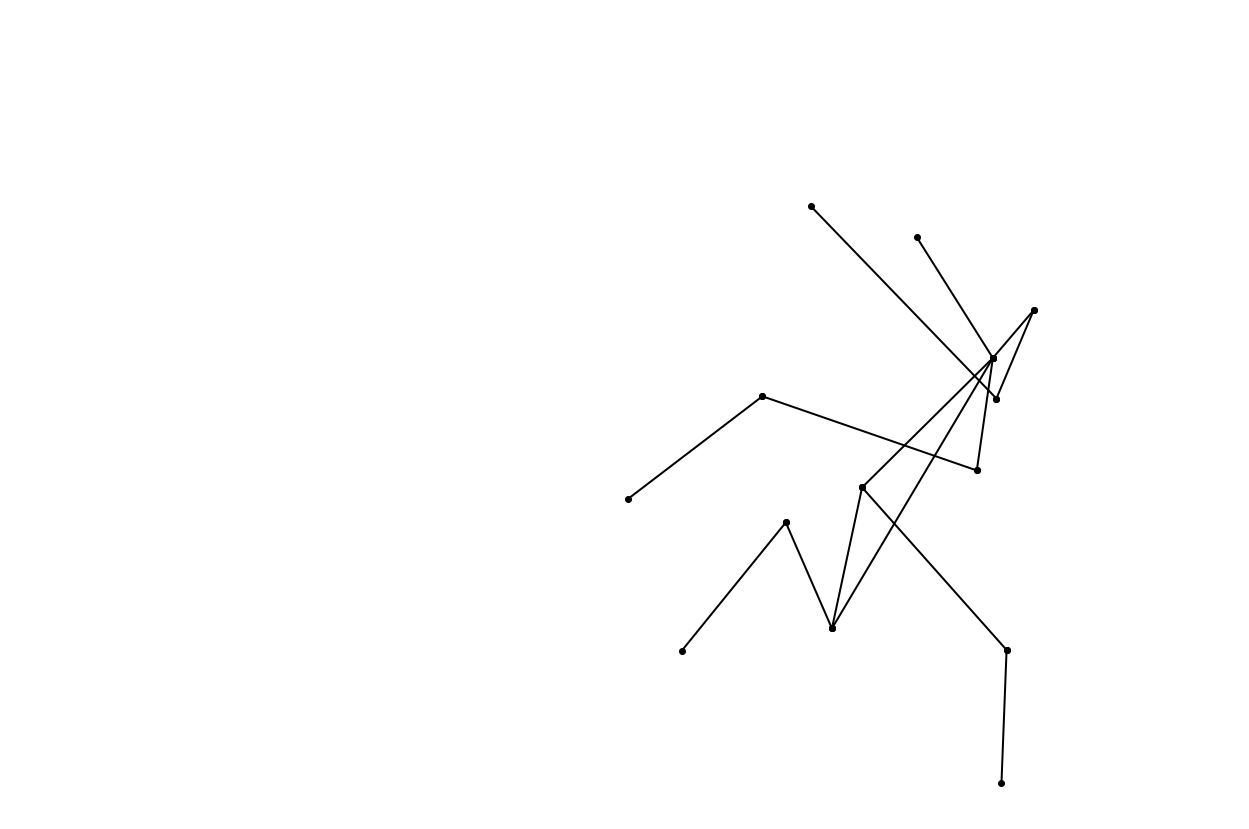

In [228]:
#from keras.models import load_model
#salsa_model = load_model("../models/threelayerLSTM.h5")
import time

d = np.random.randint(1, 71)
p = np.random.randint(0, len(pose_data_by_dancer[d]))
x = np.array([pose_data_by_dancer[d][p: p+seqLen]])
gen_salsa = genSalsa(x, salsa_model, 48)
#y_test = salsa_model.predict(x)
#print(x)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose_mod(flat_to_pose(gen_salsa[0,seqLen+1,:]))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


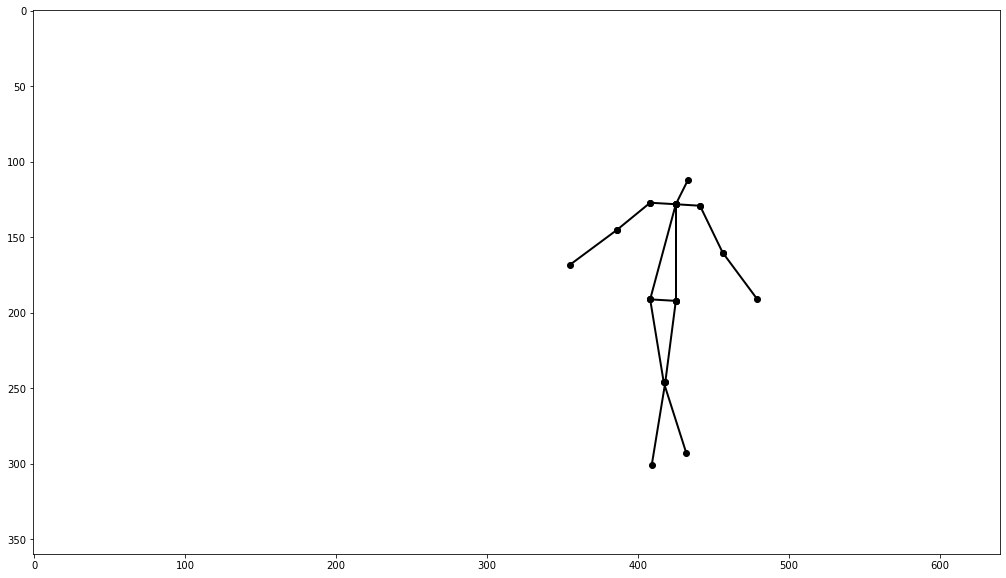

In [229]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

x_for_anim = gen_salsa

plt.rcParams['figure.figsize'] = [20, 10]                              
fig = plt.figure()
ax = plt.axes(xlim=(0, 640), ylim=(0, 360))
                              
def animate(i):
    ax.clear()
    pose = x_for_anim[0][i].reshape((-1, 2))
    #print(pose)
    imgArray = np.ones((360, 640))
    ax.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
    for pair in POSE_PAIRS_MOD:
        # Checking just xcoord for valid point is enough
        valid_pt1 = (pose[pair[0]][0] != -1)
        valid_pt2 = (pose[pair[1]][0] != -1)
        if valid_pt1 and valid_pt2:
            xs = [pose[pair[0]][0], pose[pair[1]][0]]
            ys = [pose[pair[0]][1], pose[pair[1]][1]]
            ax.plot(xs, ys,'ko-', linewidth=2)                         

anim = FuncAnimation(fig, animate, frames=56, interval=125)
anim
anim.save('../preds/72Hidden_302iters_c.gif', writer='imagemagick')

In [230]:
salsa_model.save("../models/threelayerLSTM_relu_36kp_8seql_LrgHidden302Iters.h5")

In [232]:
salsa_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 8, 72)             31392     
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 72)             41760     
_________________________________________________________________
lstm_12 (LSTM)               (None, 72)                41760     
_________________________________________________________________
dense_4 (Dense)              (None, 36)                2628      
Total params: 117,540
Trainable params: 117,540
Non-trainable params: 0
_________________________________________________________________
